# universal estimator

## Exp-1
Show that the error decreases when the parameter search space gets smaller.

**Research question**: Is the search space size of the parameter $d$ of a univariate distribution $f(d)$ has an affect on the learning and the prediction errors?

Let $f(d)$ be a one dimensional function, that returns a samples vector drawn from a univariate distribution (e.g., log-normal).

1. Generate a sample (256 observations) using $f$ e.g: $sample = f(d=0.92, size=256)$
2. Write a function: $estimator(f, sample)$ which learns the parameter $d$ of $f$ from the sample.

> - Init: search_space = (0,1)
> - Iterate:
>   1. Generate synthetic data-sets ( train / test ) using $f$ (within the parameter search space)
>   2. Fit a DNN model, error = | pred-set - test-set |
>   3. Predict the parameter $d\_pred$ on the input sample
>   4. Narrow the search space:
>          pivot = d_pred # parameter predicted on input sample using learning model
>          margin = 2 * std(abs error of pred vs. test)
>          search_space = ( pivot - margin, pivot  + margin )
>   5. Stop when the search-space size reaches some fraction, e.g. 1/128, of the initial search space
> - Return $d\_pred$: array of d_pred produced in each iteration (3), $search\_space$: array of search-spaces (4)

3. Plot a graph:
   - $x$: size of the search-space in each iteration
   - $y$: $error = | d\_pred - d\_true |$
   - Show that the error converges to a lower limit (asymptotically)

**Results**:
- The experiment was run on the following true parameter values ( $d\_true$ ) : (0.92, 0.85, 0.66, 0.25)
- Search-space narrowing used margins $STD$ and $2STD$ (as described above)
- Learning on [N=1000, M=256] samples at each iteration (search-space)
- Values measured:
    - $MAE(pred - test)$ = ```mean_absolute_error ( predict(model, X_test), X_test )```
    - $d\_pred$ = ```predict(model, sample)```
    - $d\_pred\_error$ = ```np.abs(d_pred - d_true)```

As can be shown by the plots produced in the experiment:

1. $MAE(pred - test)$ decreases monotonically as we narrow the search-space. (exceptions in some runs?)
2. $d\_pred$, **does not** consistantly decrease we narrow the search-space (different runs produce different results).

**Observation**: 
- The search-space at each iteration is centered at ($pivot=d\_pred$) and depends on the $margin=STD(MAE(pred - test))$.  
If the error variance of $d\_pred$ is large, the true value $d\_true$ may sometimes go out of the search-space.  

   - The MAX_abs_error of the prediction on the test-set starts HIGH (~0.2) and decreases slowly
   - The prediction on the input sample (d_pred) may be in the range of [0, MAX_abs_error]
   - At some point, the error of d_pred may be larger then the search-space, therfore jump out of the search-space.
    - As this happens, the search space drifts out from the true parameter value and converge to a different final.

In [3]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space):
    """
    return a (uniform) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    return np.random.uniform(low, high, size=1)[0]

In [3]:
def get_num_bins(f, M=256, N=100000, search_space=np.array([0.0, 1.0])):
    raw, H, params = generate_data(N=N, 
                                   M=M, 
                                   sample=f, 
                                   nextConfig=lambda: next_config(search_space),
                                   nbins=-1, # calculate from samples
                                   density=False, 
                                   apply_log_scale=False)
    nbins = H.shape[1]
    return nbins

# NUM_BINS = get_num_bins(f=sample_lognormal, M=256, N=100000, search_space=np.array([0.0, 1.0]))
NUM_BINS = 346

In [4]:
def MAE(e, axis=-1):
    """mean absolute error"""
    return np.mean(np.abs(e), axis=axis)

def estimator_exp_1(f, sample, d_true):
    """
    Learn parameters of f, from sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # experiment results
    res = {
        'search_space': [],
        'pred_params': [],
        'test_params': [],
        'pred_params_MAE': [],
        'd_true': d_true,
        'd_pred': [],
    }

    # number of observations in sample
    M = len(sample)
    N = 1000
    nbins = NUM_BINS
    initial_search_space = np.array([0.0, 1.0])

    # Generate a histogram for the input *sample*
    H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
    H_sample = np.reshape(H_sample, (1, -1))
    print(f'*** input histogram max value: {np.max(H_sample)}, nbins={nbins}')
    
    # Iterate
    search_space = initial_search_space
    initial_search_space_width = initial_search_space[1] - initial_search_space[0]
    it = 0
    num_trials = 10
    while True:
        
        it += 1
        
        d_pred_array = np.zeros(num_trials)
        
        for it2 in range(num_trials):
        
            # 1. Generate synthetic data-sets (train/test) using f (within search_space)
            # -----------------------------------------------------------------------------------------------
            print()
            print(f'iteration {it} (trial {it2+1}/{num_trials}) - search_space: {search_space}')
            print(f'generating data (M={M}, N={N}) ...', end=' ')

            raw, H, params = generate_data(N=N, 
                                           M=M, 
                                           sample=f, 
                                           nextConfig=lambda: next_config(search_space),
                                           nbins=nbins,
                                           density=False, 
                                           apply_log_scale=False)

            H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                          params, 
                                                                          test_size=0.25, 
                                                                          random_state=RANDOM_STATE)
            print(f'train histogram shape: {H_train.shape}', end=' ')

            # 2. Fit a DNN model to train-set and predict on test-set
            # -----------------------------------------------------------------------------------------------

            # train
            print(f'training dnn model ...')
            start_time = time.time()
            dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
            train_time = time.time() - start_time

            # predict
            pred_params = dnn_model.predict(H_test).flatten()

            # calc mean/max absolute error
            e = pred_params - test_params
            pred_params_MAE = MAE(e)
            print(f'*** test_MEAN_abs_error: {pred_params_MAE:.4f}')
            test_MAX_abs_error = np.max( np.abs(e) )
            print(f'*** test_MAX_abs_error: {test_MAX_abs_error:.4f}')
            test_3_STD = 3 * np.std(e)
            print(f'*** test_3_STD: {test_3_STD:.4f}')

            # 3. Predict the parameter (d_pred) on the input sample
            # -----------------------------------------------------------------------------------------------

            d_pred = dnn_model.predict(H_sample).flatten()[0]
            print(f'*** d_pred: {d_pred:.4f}', end=' ')
            print(f'*** abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
            d_pred_array[it2] = d_pred
        

        # take the mean
        avg_d_pred = np.mean(d_pred_array)
        print()
        print(f'*** avg_d_pred: {d_pred:.4f}, abs(avg_d_pred - d_true): {abs(avg_d_pred - d_true):.4f}')
        d_pred_STD = np.std(d_pred_array)
        print(f'*** STD(d_pred) = {d_pred_STD:.4f}')
        pred_params_STD = np.std(e)
        print(f'*** STD(params_pred) = {pred_params_STD:.4f}')
        
        d_pred = avg_d_pred
        
        # save results of last iteration + mean(d_pred)
        res['test_params'].append(test_params)
        res['pred_params'].append(pred_params)
        res['search_space'].append(search_space)
        res['pred_params_MAE'].append(pred_params_MAE)
        res['d_pred'].append(d_pred)
        
#         #lilox
#         dist = np.sqrt(np.sum((H_sample - H_train)**2, axis=1))
#         idx = np.argmin(dist)
#         d_pred_tag = train_params[idx]
#         print(f'*** d_pred_tag: {d_pred_tag:.6f}')
        
        # 4. Narrow the search space:
        # -----------------------------------------------------------------------------------------

        pivot = d_pred
#         pivot = d_pred_tag
        
#         idx = np.argmin(np.abs(d_pred - pred_params))
#         pred_abs_error = np.abs(pred_params[idx] - test_params[idx])
# #         std = np.std(e)
#         if (pred_abs_error > pred_params_MAE):
#             print(f'*** *** *** lilo: pred_abs_error > std')
#             continue

        margin_with_STD = True
#         margin_with_STD = False
        if margin_with_STD:
#             std_factor = 1
#             std_factor = 2
            std_factor = 3

#             pred_params_STD = np.std(e)
#             margin = std_factor * pred_params_STD
            d_pred_STD = np.std(d_pred_array)
            margin = std_factor * d_pred_STD

            print(f'*** pivot = d_pred: {pivot:.4f}, margin = {std_factor} * STD(d_pred) = {margin:.4f}')
        else:
            margin = test_MAX_abs_error
            print(f'pivot = d_pred: {pivot:.4f}, margin = test_MAX_abs_error = {margin:.4f}')

        # (pivot +- margin) may fall outside the search_space
        left = pivot - margin
        right = pivot + margin
        if left < search_space[1] and right > search_space[0]:
            next_search_space = np.array([ 
                max(search_space[0], pivot - margin), 
                min(search_space[1], pivot + margin)])
        else:
            next_search_space = search_space
        
        # if no change in search_space, narrow by epsilon (from both sides)
        if np.array_equal(search_space, next_search_space):
            epsilon = 0.0001
#             epsilon = max(epsilon, 0.1 * margin)
#             if margin_with_STD:
#                 epsilon = max(epsilon, 0.1 * pred_params_STD)
#             else:
#                 epsilon = max(epsilon, 0.01 * test_MAX_abs_error)
            print(f'no change in search_space. narrowing by epsilon: {epsilon:.4f}')
            search_space = np.array([search_space[0] + epsilon, search_space[1] - epsilon])
        else:
            search_space = next_search_space
        
        # stop condition: size of the search-space (high-low) is 1/128 of the original
        # -----------------------------------------------------------------------------------------
        
        search_space_width = search_space[1] - search_space[0]
#         search_space_shrink_factor = 1/16
#         search_space_shrink_factor = 1/64
        search_space_shrink_factor = 1/128
        if search_space_width < search_space_shrink_factor * initial_search_space_width:
            print('stop -----------------------------------------------------------------')
            print(f'final search_space_width: {search_space_width:.4f}')
            print(f'pred_params_MAE: {pred_params_MAE:.4f}')
            print(f'd_true: {d_true:.4f}', end=', ')
            print(f'd_pred: {d_pred:.4f}')
            break
            

    res['search_space'] = np.array(res['search_space'])
    res['test_params'] = np.array(res['test_params'])
    res['pred_params'] = np.array(res['pred_params'])
    res['pred_params_MAE'] = np.array(res['pred_params_MAE'])
    res['d_pred'] = np.array(res['d_pred'])
    
    return res

In [5]:
# import numpy as np

# points = np.array([[1,2,6], [1,2,4], [1,2,3]])
# single_point = np.array([1.1, 2.1, 3.1])

# dist = np.sqrt(np.sum((single_point - points)**2, axis=1))

# # dist = (single_point - points)**2
# # dist = np.sum(dist, axis=1)
# # dist = np.sqrt(dist)
# print(dist)
# print(np.argmin(dist))

### Fit (lognormal)

In [6]:
d_true = 0.92
# d_true = 0.85
print()
print(f'param true value: {d_true}')
sample = sample_lognormal(config=d_true, size=256)
res = estimator_exp_1(f=sample_lognormal, sample=sample, d_true=d_true)



param true value: 0.92

iteration 1 (trial 1/10) - search_space: [0. 1.]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0575
*** test_MAX_abs_error: 0.1821
*** test_3_STD: 0.2171
*** d_pred: 0.8470 *** abs(d_pred - d_true): 0.0730

iteration 1 (trial 2/10) - search_space: [0. 1.]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0507
*** test_MAX_abs_error: 0.2113
*** test_3_STD: 0.1905
*** d_pred: 0.8342 *** abs(d_pred - d_true): 0.0858

iteration 1 (trial 3/10) - search_space: [0. 1.]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0524
*** test_MAX_abs_error: 0.1778
*** test_3_STD: 0.1931
*** d_pred: 0.8183 *** abs(d_pred - d_true): 0.1017

iteration 1 (trial 4/10) - search_space: [0. 1.]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn 

*** test_MEAN_abs_error: 0.0445
*** test_MAX_abs_error: 0.1369
*** test_3_STD: 0.1612
*** d_pred: 0.8831 *** abs(d_pred - d_true): 0.0369

iteration 3 (trial 9/10) - search_space: [0.7577 0.9875]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0449
*** test_MAX_abs_error: 0.2346
*** test_3_STD: 0.1710
*** d_pred: 0.8909 *** abs(d_pred - d_true): 0.0291

iteration 3 (trial 10/10) - search_space: [0.7577 0.9875]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0393
*** test_MAX_abs_error: 0.1785
*** test_3_STD: 0.1474
*** d_pred: 0.9066 *** abs(d_pred - d_true): 0.0134

*** avg_d_pred: 0.9066, abs(avg_d_pred - d_true): 0.0325
*** STD(d_pred) = 0.0190
*** STD(params_pred) = 0.0491
*** pivot = d_pred: 0.8875, margin = 3 * STD(d_pred) = 0.0571

iteration 4 (trial 1/10) - search_space: [0.8303 0.9446]
generating data (M=256, N=1000) ... train histogra

*** test_MEAN_abs_error: 0.0071
*** test_MAX_abs_error: 0.0172
*** test_3_STD: 0.0250
*** d_pred: 0.8749 *** abs(d_pred - d_true): 0.0451

iteration 6 (trial 6/10) - search_space: [0.8616 0.8903]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0070
*** test_MAX_abs_error: 0.0164
*** test_3_STD: 0.0242
*** d_pred: 0.8765 *** abs(d_pred - d_true): 0.0435

iteration 6 (trial 7/10) - search_space: [0.8616 0.8903]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0073
*** test_MAX_abs_error: 0.0158
*** test_3_STD: 0.0249
*** d_pred: 0.8758 *** abs(d_pred - d_true): 0.0442

iteration 6 (trial 8/10) - search_space: [0.8616 0.8903]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0071
*** test_MAX_abs_error: 0.0168
*** test_3_STD: 0.0246
*** d_pred: 0.8780 *** abs(d_pred - d_true): 0.

### Plot

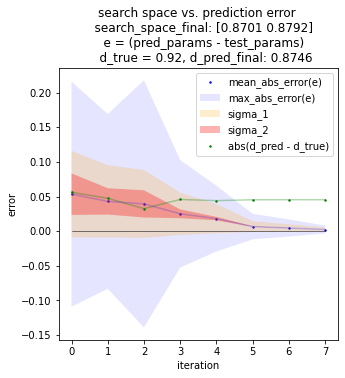

In [7]:
def plot_search_space_size_vs_d_pred_error(res):

    search_space = res['search_space']
    search_space_width = search_space[:,1] - search_space[:,0]
    search_space_final = search_space[-1]
    
    d_true = res['d_true']
  
    d_pred = res['d_pred']
    d_pred_final = d_pred[-1]
    d_pred_abs_error = np.abs(d_pred - d_true)

    pred_params = res['pred_params']
    test_params = res['test_params']

    # errors in each iteration
    e = pred_params - test_params
    
    # num-iterations
    n = e.shape[0]
    
    # avg error of each iteration
    mu = np.mean(e, axis=1).reshape((n,-1))
    
    # STD in each iteration
    sigma_1 = np.std(e, axis=1)

    # sigma_2
    mu = np.mean(e, axis=1).reshape(n, 1)
    var_2 = 1/n * np.sum(np.square(np.square(e - mu) - np.square(sigma_1).reshape(n,1)), axis=1)
    sigma_2 = np.sqrt(var_2)

    # iteration number
    x = np.array(range(n))

#     y1 = sigma_1
    y1 = MAE(e)
    y2 = d_pred_abs_error
    
#     LOG = True
    LOG = False
    if LOG:
        y1 = np.log10(y1)
        y2 = np.log10(y2)

    max_abs_error_e = np.max(np.abs(e), axis=1)
    
   # =======
   # PLOT
   # =======
    
    title = f'search space vs. prediction error \n\
    search_space_final: {search_space_final} \n\
    e = (pred_params - test_params) \n\
    d_true = {d_true}, d_pred_final: {d_pred_final:.4f}'
    
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.xlabel('iteration')
    if LOG:
        plt.ylabel('log10(error)')
    else:
        plt.ylabel('error')
    
    plt.plot(x, np.zeros(n), zorder=2, c='black', linewidth=0.5)
    
    plt.scatter(x, y1, zorder=1, s=2, c='blue', label='mean_abs_error(e)')
    plt.plot(x, y1, zorder=2, c='blue', alpha=0.2)
    
    # confidence_interval_1: MAE(e) +- max_abs_error(e)
    plt.fill_between(range(len(x)), 
                     y1 - max_abs_error_e, y1 + max_abs_error_e, 
                     facecolor='blue', alpha=0.1, label='max_abs_error(e)')
    
    # confidence_interval_2: MAE(e) +- sigma_1
    plt.fill_between(range(len(x)), 
                     y1 - sigma_1, y1 + sigma_1, 
                     facecolor='orange', alpha=0.2, label='sigma_1')
    
    # confidence_interval_3: MAE(e) +- sigma_2
    plt.fill_between(range(len(x)), 
                     y1 - sigma_2, y1 + sigma_2, 
                     facecolor='red', alpha=0.3, label='sigma_2')

    # y2 (d_pred)
    plt.scatter(x, y2, zorder=1, s=2, c='green', label='abs(d_pred - d_true)')
    plt.plot(x, y2, zorder=2, c='green', alpha=0.3)
    
    plt.legend(loc='upper right')
    
    plt.show()

plot_search_space_size_vs_d_pred_error(res)

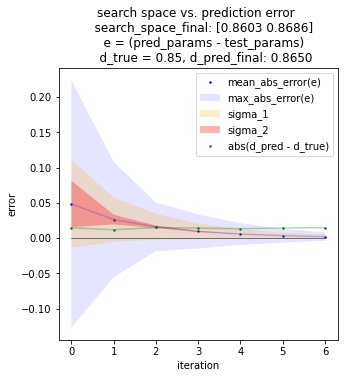

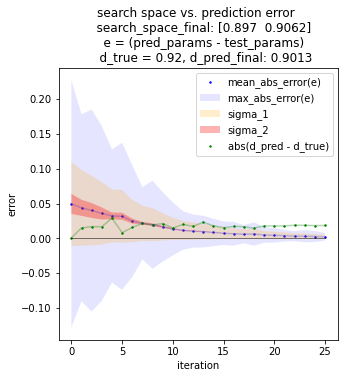

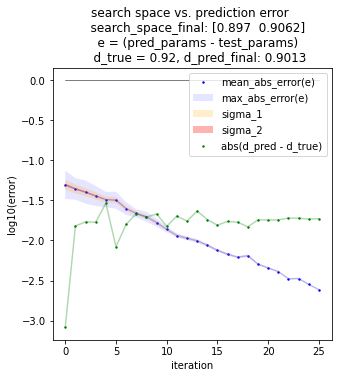


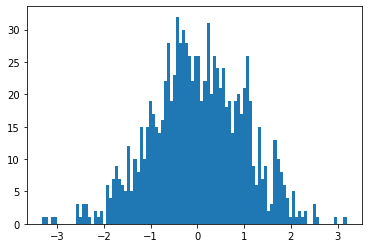

In [5]:
x = np.random.randn(1000)
_ = plt.hist(x, bins=100)